In [2]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns
import tensorflow as tf
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [10]:
df = pd.read_csv("IB_indexed.csv")

In [11]:
df = df.set_index(['UploadTime'])
df.index = pd.to_datetime(df.index)
# df.to_csv("IB_indexed.csv")

In [17]:
df_cc_resample = df.Usage_CC.resample('h').mean()

In [7]:
display(df_cc_resample)

UploadTime
2020-08-10 00:00:00     98754.0
2020-08-10 01:00:00    216580.0
2020-08-10 02:00:00    224280.0
2020-08-10 03:00:00    224280.0
2020-08-10 04:00:00    224164.0
                         ...   
2020-09-13 19:00:00    231078.0
2020-09-13 20:00:00    171252.0
2020-09-13 21:00:00    171480.0
2020-09-13 22:00:00    170635.0
2020-09-13 23:00:00     93794.0
Freq: H, Name: Usage_CC, Length: 840, dtype: float64

In [8]:
description = df_cc_resample.describe().transpose()
display(description)

count       840.000000
mean     176490.157143
std       51443.668562
min       31238.000000
25%      140520.000000
50%      176675.500000
75%      209464.500000
max      326492.000000
Name: Usage_CC, dtype: float64

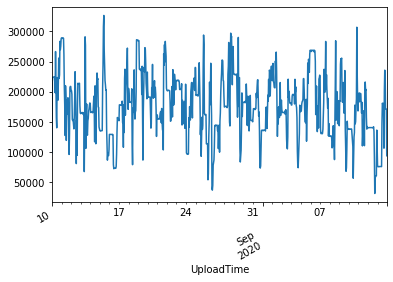

In [9]:
plot_features = df_cc_resample
plot_features.index = df_cc_resample.index
_ = plot_features.plot(subplots=True)
plt.show()

In [60]:
# split data into train, val, and test
n = len(df_cc_resample)
train_df = df_cc_resample[0:int(n*0.7)]
val_df = df_cc_resample[int(n*0.7):int(n*0.9)]
test_df = df_cc_resample[int(n*0.9):]

In [61]:
print(train_df)

UploadTime
2020-08-10 00:00:00     98754.0
2020-08-10 01:00:00    216580.0
2020-08-10 02:00:00    224280.0
2020-08-10 03:00:00    224280.0
2020-08-10 04:00:00    224164.0
                         ...   
2020-09-03 07:00:00    167124.0
2020-09-03 08:00:00    168114.0
2020-09-03 09:00:00    162420.0
2020-09-03 10:00:00    170294.0
2020-09-03 11:00:00    158286.0
Freq: H, Name: Usage_CC, Length: 588, dtype: float64


In [63]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [62]:
def split_window(sequence, steps):
    x_input, y_label = list(), list()
    for i in range(len(sequence)):
        window_end = i + steps
        if window_end == len(sequence):
            break
#         x_input.append(sequence.values[i:window_end])
        x_input.append(sequence[i:window_end])
        y_label.append(sequence[window_end])
    return np.array(x_input), np.array(y_label)

In [64]:
# split to 6-hr windows, 5 inputs and 1 label
n_steps = 5
x_train, y_train = split_window(train_df, 5)
x_val, y_val = split_window(val_df, 5)
x_test, y_test = split_window(test_df, 5)
# for i in range(len(x)):
#     print(x[i], y[i])

In [65]:
print(x_train)

[[-1.6500697   0.70825332  0.86237115  0.86237115  0.86004937]
 [ 0.70825332  0.86237115  0.86237115  0.86004937  0.86237115]
 [ 0.86237115  0.86237115  0.86004937  0.86237115  0.86237115]
 ...
 [-0.31669028 -0.31669028 -0.31669028 -0.28162347 -0.26180832]
 [-0.31669028 -0.31669028 -0.28162347 -0.26180832 -0.37577546]
 [-0.31669028 -0.28162347 -0.26180832 -0.37577546 -0.21817497]]


In [66]:
# reshape from [samples, timesteps] to [samples, timesteps, features]
n_features = 1
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],n_features))
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],n_features)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],n_features)

In [67]:
print(x_train)

[[[-1.6500697 ]
  [ 0.70825332]
  [ 0.86237115]
  [ 0.86237115]
  [ 0.86004937]]

 [[ 0.70825332]
  [ 0.86237115]
  [ 0.86237115]
  [ 0.86004937]
  [ 0.86237115]]

 [[ 0.86237115]
  [ 0.86237115]
  [ 0.86004937]
  [ 0.86237115]
  [ 0.86237115]]

 ...

 [[-0.31669028]
  [-0.31669028]
  [-0.31669028]
  [-0.28162347]
  [-0.26180832]]

 [[-0.31669028]
  [-0.31669028]
  [-0.28162347]
  [-0.26180832]
  [-0.37577546]]

 [[-0.31669028]
  [-0.28162347]
  [-0.26180832]
  [-0.37577546]
  [-0.21817497]]]


In [68]:
# vanilla lstm: only one hidden layer of lstm + one output layer
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', # optimizer
              loss='mse',
             metrics=[tf.metrics.MeanAbsoluteError()]) # loss function # metrics to monitor

In [69]:
# fit model
model.fit(x_train, y_train, epochs=200, verbose=0
          , validation_data=(x_val, y_val)
         )

In [70]:
# evaluate model using test data
results = model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 1ms/step - loss: 0.4311 - mean_absolute_error: 0.4458


In [55]:
# generate predictions
predictions = model.predict(x_test, verbose=0)
print(predictions)

[[145298.39 ]
 [153815.7  ]
 [171203.78 ]
 [181611.7  ]
 [293897.34 ]
 [232159.77 ]
 [197393.62 ]
 [179566.7  ]
 [211166.98 ]
 [190368.02 ]
 [194545.48 ]
 [178797.33 ]
 [199216.48 ]
 [191704.55 ]
 [194854.89 ]
 [174549.14 ]
 [166819.27 ]
 [184867.53 ]
 [125970.87 ]
 [143043.61 ]
 [120822.24 ]
 [157907.73 ]
 [162898.77 ]
 [112645.32 ]
 [212691.66 ]
 [208704.36 ]
 [198569.69 ]
 [201592.61 ]
 [163378.77 ]
 [152743.31 ]
 [147270.42 ]
 [142002.9  ]
 [139836.7  ]
 [138773.88 ]
 [138594.5  ]
 [139075.67 ]
 [138870.14 ]
 [138986.84 ]
 [138962.61 ]
 [138814.17 ]
 [138946.28 ]
 [138968.17 ]
 [138968.56 ]
 [138892.72 ]
 [138293.53 ]
 [139080.6  ]
 [140269.5  ]
 [132050.45 ]
 [102315.695]
 [ 42909.746]
 [ 71132.21 ]
 [ 98579.516]
 [ 61010.13 ]
 [ 59012.938]
 [128494.38 ]
 [ 98757.87 ]
 [ 81766.98 ]
 [ 79573.37 ]
 [ 81508.71 ]
 [ 78598.805]
 [ 74662.414]
 [ 75233.555]
 [ 74939.586]
 [ 75164.09 ]
 [ 75094.27 ]
 [ 74968.29 ]
 [ 75009.48 ]
 [143682.25 ]
 [161510.67 ]
 [173962.97 ]
 [179015.78 ]
 [1701

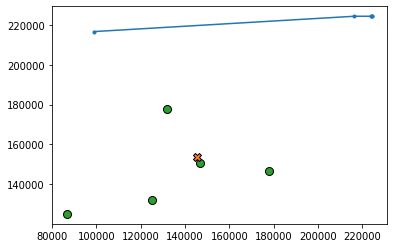

In [56]:
# blue line
plt.plot(x_train[0], x_train[1],
        label='Inputs', marker='.', zorder=-10)
# green dots
plt.scatter(x_test[0], x_test[1],
            edgecolors='k', label='Labels', c='#2ca02c', s=64)
# orange x's
plt.scatter(predictions[0], predictions[1],
            marker='X', edgecolors='k', label='Predictions',
            c='#ff7f0e', s=64)

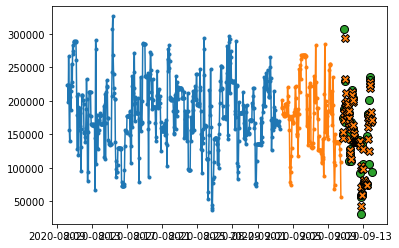

In [57]:
# blue line
plt.plot(train_df.index[n_steps:], y_train,
        label='Inputs', marker='.', zorder=-10)
# orange line
plt.plot(val_df.index[n_steps:], y_val,
        label='Val', marker='.', zorder=-10)
# green dots
plt.scatter(test_df.index[n_steps:], y_test,
            edgecolors='k', label='Labels', c='#2ca02c', s=64)
# orange x's
plt.scatter(test_df.index[n_steps:], predictions,
            marker='X', edgecolors='k', label='Predictions',
            c='#ff7f0e', s=64)

(18516.0, 18518.0)

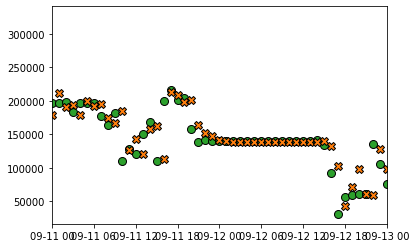

In [58]:
# blue line
plt.plot(train_df.index[n_steps:], y_train,
        label='Inputs', marker='.', zorder=-10)
# orange line
plt.plot(val_df.index[n_steps:], y_val,
        label='Val', marker='.', zorder=-10)
# green dots
plt.scatter(test_df.index[n_steps:], y_test,
            edgecolors='k', label='Labels', c='#2ca02c', s=64)
# orange x's
plt.scatter(test_df.index[n_steps:], predictions,
            marker='X', edgecolors='k', label='Predictions',
            c='#ff7f0e', s=64)
axes = plt.gca()
axes.set_xlim([datetime.datetime.strptime("2020-09-11 00:00:00", "%Y-%m-%d %H:%M:%S"), datetime.datetime.strptime("2020-09-13 00:00:00", "%Y-%m-%d %H:%M:%S")])

(18517.0, 18518.0)

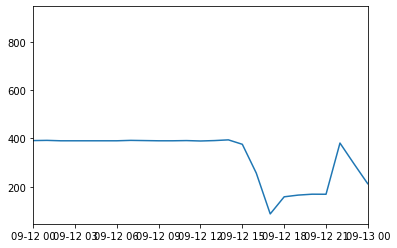

In [24]:
plt.plot(df_cc_resample.index, df_cc_resample)
axes = plt.gca()
axes.set_xlim([datetime.datetime.strptime("2020-09-12 00:00:00", "%Y-%m-%d %H:%M:%S"), datetime.datetime.strptime("2020-09-13 00:00:00", "%Y-%m-%d %H:%M:%S")])